## 6.2 순환 신경망(RNN) 이해하기

- [[링크](http://excelsior-cjh.tistory.com/183)] 참고
- **순환 신경망**(RNN, Recurrent Neural Network)는 시퀀스의 원소를 순회하면서 지금까지 처리한 정보를 **상태(state)**에 저장한다.
- RNN은 내부에 루프(loop)을 가진 신경망의 한 종류다.

$$
\begin{align*}
h_t &= \tanh \left(\mathbf{X}_{t} \cdot \mathbf{W}_{x} + h_{t-1} \cdot \mathbf{W}_{h} + \mathbf{b} \right) \\ \mathbf{Y}_{t} &= \mathbf{W}^{T}_{y} \cdot h_{t}
\end{align*}
$$

![](./images/rnn04.png)

### NumPy를 이용한 RNN 구현하기

1. 이 RNN은 형태가 `(timesteps, input_features)`인 2D인 텐서로 인코딩된 벡터의 시퀀스를 입력받는다.
2. 이 시퀀스는 타임스텝(`timesteps`)을 따라 반복된다.
3. 각 타임스텝 `t`에서 현재 상태(`state`)와 입력을 연결하여 출력을 계산한다.
4. 이 출력을 다음 스텝(`t+1`)의 상태로 설정한다.
    - 첫 번째 타임스텝에서는 출력이 정의되어있지 않으므로 **초기 상태**인 0벡터로 상태를 초기화한다.

In [3]:
import numpy as np

timesteps = 100  # 입력 시퀀스에 있는 타임스텝의 수
input_features = 32  # 입력 특성의 차원
output_features = 64  # 출력 특성의 차원

inputs = np.random.random((timesteps, input_features))  # 입력 데이터(X): 예제를 위해 생성한 난수

state_t = np.zeros((output_features,))  # 초기 상태(h0): 모두 0인 벡터

W_x = np.random.random((output_features, input_features))
W_h = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

outputs = []
for input_t in inputs:  # input_t는 형태가 (input_featurs,)인 벡터다
    # 입력(x_t)과 현재 상태(이전 출력, h_{t-1})을 연결하여 현재 출력(h_t)를 얻는다.
    h_t = np.tanh(np.dot(W_x, input_t) + np.dot(W_h, state_t) + b)
    outputs.append(h_t)  # 이 출력을 리스트에 저장
    state_t = h_t  # 다음 타임스텝을 위해 네트워크의 상태를 업데이트

# 최종 출력은 형태가 (timestpes, output_features) = (100, 64)
final_output_sequence = np.stack(outputs, axis=0)

In [4]:
final_output_sequence.shape

(100, 64)

---

In [1]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.4'

### 6.2.1 케라스의 순환 층 - `SimpleRNN`

넘파이로 간단하게 구현한 과정이 실제 케라스의 [`SimpleRNN`](https://keras.io/layers/recurrent/#simplernn) 층에 해당합니다:

In [2]:
from keras.layers import SimpleRNN

케라스에 있는 모든 순환 층과 동일하게 SimpleRNN은 두 가지 모드로 실행할 수 있습니다. 

- 입력 시퀀스에 대한 마지막 출력만 반환할 수 있습니다(크기가 `(batch_size, output_features)` 인 2D 텐서). 
- 각 타임스텝의 출력을 모은 전체 시퀀스를 반환하거나(크기가 `(batch_size, timesteps, output_features)` 인 3D 텐서)
    - 이 모드는 객체를 생성할 때 `return_sequences` 매개변수로 선택할 수 있습니다. 
    - return_sequences: Boolean. Whether to return the last output
        in the output sequence, or the full sequence.

예제를 살펴보죠:

#### 마지막 타임스텝의 출력만 얻기

In [3]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))  # 32 * 32 * 2(W_x, W_h) + 32
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


#### 전체 상태 시퀀스를 얻기

In [4]:
from keras import backend as K

K.clear_session()

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 차례대로 쌓는 것이 유용할 때가 있습니다. 
- 이런 설정에서는 **중간 층들이 전체 출력 시퀀스를 반환하도록 설정**해야 합니다:

![](./images/deep-rnn.PNG)

In [5]:
K.clear_session()

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # 맨 위 층만 마지막 출력만 반환
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


#### IMDB 영화 리뷰 분류 문제에 적용하기

이제 IMDB 영화 리뷰 분류 문제에 적용해 보죠. 먼저 데이터를 전처리합니다:

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # 특성으로 사용할 단어의 수
maxlen = 500  # 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용)
batch_size = 32

print('데이터 로딩...')
(train_inputs, train_labels), (test_inputs, test_labels) = imdb.load_data(num_words=max_features)
print(len(train_inputs), '훈련 시퀀스')
print(len(test_inputs), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
train_inputs = sequence.pad_sequences(train_inputs, maxlen=maxlen)
test_inputs = sequence.pad_sequences(test_inputs, maxlen=maxlen)
print('train_inputs shape :', train_inputs.shape)
print('test_inputs shape :', test_inputs.shape)

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
train_inputs shape : (25000, 500)
test_inputs shape : (25000, 500)


`Embedding` 층과 `SimpleRNN` 층을 사용해 간단한 순환 네트워크를 훈련시켜 보겠습니다:

In [9]:
from keras.layers import Dense

K.clear_session()

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(train_inputs, train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 13s 670us/step - loss: 0.6435 - acc: 0.6130 - val_loss: 0.6037 - val_acc: 0.6376
Epoch 2/10
20000/20000 [==============================] - 12s 588us/step - loss: 0.4152 - acc: 0.8223 - val_loss: 0.4209 - val_acc: 0.8230
Epoch 3/10
20000/20000 [==============================] - 12s 588us/step - loss: 0.3163 - acc: 0.8721 - val_loss: 0.3826 - val_acc: 0.8232
Epoch 4/10
20000/20000 [==============================] - 12s 588us/step - loss: 0.2653 - acc: 0.8972 - val_loss: 0.3976 - val_acc: 0.8210
Epoch 5/10
20000/20000 [==============================] - 12s 589us/step - loss: 0.2131 - acc: 0.9205 - val_loss: 0.4215 - val_acc: 0.8030
Epoch 6/10
20000/20000 [==============================] - 12s 590us/step - loss: 0.1752 - acc: 0.9339 - val_loss: 0.3799 - val_acc: 0.8568
Epoch 7/10
20000/20000 [==============================] - 12s 589us/step - loss: 0.1431 - acc: 0.9497 - val_loss: 0.4

이제 훈련과 검증의 손실과 정확도를 그래프로 그립니다:

In [10]:
import matplotlib.pyplot as plt

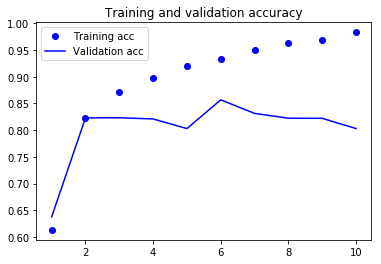

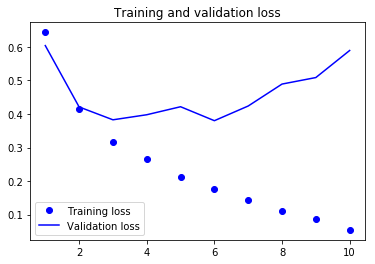

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

3장에서 이 데이터셋을 사용한 첫 번째 모델에서 얻은 테스트 정확도는 87%였습니다. 안타깝지만 간단한 순환 네트워크는 이 기준 모델보다 성능이 높지 않습니다(85% 정도의 검증 정확도를 얻었습니다). 
- 이런 원인은 전체 시퀀스가 아니라 처음 500개의 단어만 입력에 사용했기 때문입니다. 이 RNN은 기준 모델보다 얻은 정보가 적습니다.
- 다른 이유는 SimpleRNN이 텍스트와 같이 긴 시퀀스를 처리하는데 적합하지 않기 때문입니다. 

더 잘 작동하는 다른 순환 층이 있습니다. 조금 더 고급 순환 층을 살펴보죠.

---

### 6.2.2 LSTM과 GRU 층 이해하기

- [[링크](http://excelsior-cjh.tistory.com/185)] 참고
- 케라스에는 `SimpleRNN`외에 다른 순환층이 있는데, [`LSTM`](https://keras.io/layers/recurrent/#lstm)과 [`GRU`](https://keras.io/layers/recurrent/#gru) 2 개가 있다.
- `SimpleRNN`은 이론적으로 타임스텝 `t`에서 이전 모든 타임스텝의 정보를 유지할 수 있지만, 실제로는 긴 시간에 걸친 의존성은 학습할 수 없는 것이 문제다.
- `SimpleRNN`은 **vanishing gradient** 또는 **exploding gradient** 문제가 발생할 가능성이 높다.
- 이 문제를 해결하기 위해 고안된 것이 **LSTM**과 **GRU**이다.

#### LSTM Cell

![](./images/lstm.PNG)

- LSTM 셀에서는 상태(state)가 두 개의 벡터 $\mathbf{h}_t$와 $\mathbf{c}_t$로 나누어 진다는 것을 알 수 있다.
    - $\mathbf{h}_t$를 단기 상태(short-term state), 
    - $\mathbf{c}_t$를 장기 상태(long-term state)라고 볼 수 있다. 


- LSTM의 핵심은 네트워크가 장기 상태($\mathbf{c}_t$)에서 기억할 부분, 삭제할 부분,  그리고 읽어 들일 부분을 학습하는 것이다. 
- 장기 기억 $\mathbf{c}_{t-1}$은 셀의 왼쪽에서 오른쪽으로 통과하게 되는데,
    1. **forget gate**를 지나면서 일부를 기억(정보)을 잃고, 
    2. 그 다음 덧셈(+) 연산으로 **input gate**로 부터 새로운 기억 일부를 추가한다. 
    3. 이렇게 만들어진 $\mathbf{c}_t$는 별도의 추가 연산 없이 바로 출력되며, 이러한 장기 기억 $\mathbf{c}_t$는 타임 스텝마다 일부의 기억을 삭제하고 추가하는 과정을 거치게 된다. 
    4. 그리고 덧셈 연산 후에 $\mathbf{c}_t$는 복사되어 **output gate**의 $\tanh$함수로 전달되어 단기 상태 $\mathbf{h}_{t}$와 셀의 출력인 $\mathbf{y}_t$를 만든다. 

- forget, input, output 게이트(gate)의 역할은 다음과 같다.
    - **Forget gate** : $\mathbf{f}_{t}$에 의해 제어되며 장기 상태 $\mathbf{c}_{t}$의 어느 부분을 삭제할지 제어한다.
    - **Input gate** : $\mathbf{i}_{t}$에 의해 제어되며 $\mathbf{g}_{t}$의 어느 부분이 장기 상태 $\mathbf{c}_{t}$에 더해져야 하는지 제어한다.
    - **Output gate** : $\mathbf{o}_{t}$는 장기 상태 $\mathbf{c}_{t}$의 어느 부분을 읽어서 $\mathbf{h}_{t}$ 와 $\mathbf{y}_{t}$로 출력해야 하는지 제어한다.

- 다음의 식은 위의 그림에서 타임 스텝 $t$에서, 셀의 장기 상태, 단기 상태, 그리고 각 레이어의 출력을 구하는 식을 나타낸 것이다.


$$
\begin{eqnarray} 
\mathbf{f}_{t} & = & \sigma \left( \mathbf{W}_{xf}^{T} \cdot \mathbf{x}_{t} + \mathbf{W}_{hf}^{T} \cdot \mathbf{h}_{t-1} + \mathbf{b}_{f} \right) \\ \mathbf{i}_{t} & =  & \sigma \left( \mathbf{W}_{xi}^{T} \cdot \mathbf{x}_{t} + \mathbf{W}_{hi}^{T} \cdot \mathbf{h}_{t-1} + \mathbf{b}_{i} \right) \\ \mathbf{o}_{t} & = & \sigma \left( \mathbf{W}_{xo}^{T} \cdot \mathbf{x}_{t} + \mathbf{W}_{ho}^{T} \cdot \mathbf{h}_{t-1} + \mathbf{b}_{o} \right) \\ \mathbf{g}_{t} & = & \tanh \left( \mathbf{W}_{xg}^{T} \cdot \mathbf{x}_{t} + \mathbf{W}_{hg}^{T} \cdot \mathbf{h}_{t-1} + \mathbf{b}_{g} \right) \\ \mathbf{c}_{t} & = & \mathbf{f}_{t} \otimes \mathbf{c}_{t-1} + \mathbf{i}_{t} \otimes \mathbf{g}_{t} \\ \mathbf{y}_{t}, \mathbf{h}_{t} & = & \mathbf{o}_{t} \otimes \tanh \left( \mathbf{c}_{t} \right) 
\end{eqnarray}
$$


- $\mathbf{W}_{xf}, \mathbf{W}_{xi}, \mathbf{W}_{xo}, \mathbf{W}_{xg}$ : 입력 벡터 $\mathbf{x}_{t}$에 연결된 네 개의 레이어에 대한 가중치 행렬
- $\mathbf{W}_{hf}, \mathbf{W}_{hi}, \mathbf{W}_{ho}, \mathbf{W}_{hg}$ : 이전 타임스텝의 단기 상태 $\mathbf{h}_{t-1}$에 연결된 네 개의 레이어에 대한 가중치 행렬
- $\mathbf{b}_{f}, \mathbf{b}_{i}, \mathbf{b}_{o}, \mathbf{b}_{g}$ : 네 개의 레이어에 대한 편향(bias), [텐서플로](https://www.tensorflow.org/api_docs/python/tf/nn/rnn_cell/LSTMCell)(TensorFlow)에서는 $\mathbf{b}_{f}$ 를 `1`로 초기화하여 학습 시작시에 모든것을 잃어버리는 것을 방지한다.

#### GRU Cell

![](./images/gru.PNG)

- **GRU(Gated Recurrent Unit)** 셀은 2014년에 K. Cho(조경현) 등에 의해 ['이 논문'](https://arxiv.org/pdf/1406.1078v3.pdf)에서 제안된 LSTM 셀의 **간소화된 버전**이다.

- LSTM Cell에서의 두 상태 벡터 $\mathbf{c}_{t}$와 $\mathbf{h}_{t}$가 하나의 벡터 $\mathbf{h}_{t}$로 합쳐졌다.

- 하나의 gate controller인 $\mathbf{z}_{t}$가 **forget**과 **input** 게이트(gate)를 모두 제어한다.  $\mathbf{z}_{t}$가 `1`을 출력하면 forget 게이트가 열리고 input 게이트가 닫히며, $\mathbf{z}_{t}$가 `0`일 경우 반대로 forget 게이트가 닫히고 input 게이트가 열린다. 즉, 이전($t-1$)의 기억이 저장 될때 마다 타임 스텝 $t$의 입력은 삭제된다. 

- GRU 셀은 output 게이트가 없어 전체 상태 벡터 $\mathbf{h}_{t}$가 타임 스텝마다 출력되며, 이전 상태 $\mathbf{h}_{t-1}$의 어느 부분이 출력될지 제어하는 새로운 gate controller인 $\mathbf{r}_{t}$가 있다.

- GRU 셀의 상태(state)와 각 레이어의 출력을 계산하는 식은 다음과 같다.


$$
\begin{eqnarray} 
\mathbf{r}_{t} & = & \sigma \left( \mathbf{W}_{xr}^{T} \cdot \mathbf{x}_{t} + \mathbf{W}_{hr}^{T} \cdot \mathbf{h}_{t-1} + \mathbf{b}_{r} \right) \\ \mathbf{z}_{t} & =  & \sigma \left( \mathbf{W}_{xz}^{T} \cdot \mathbf{x}_{t} + \mathbf{W}_{hz}^{T} \cdot \mathbf{h}_{t-1} + \mathbf{b}_{z} \right) \\ \mathbf{g}_{t} & = & \tanh \left( \mathbf{W}_{xg}^{T} \cdot \mathbf{x}_{t} + \mathbf{W}_{hg}^{T} \cdot \left( \mathbf{r}_{t} \otimes \mathbf{h}_{t-1} \right) + \mathbf{b}_{g} \right) \\ \mathbf{h}_{t} & = & \mathbf{z}_{t} \otimes \mathbf{h}_{t-1} + \left( 1 - \mathbf{z}_{t} \right) \otimes \mathbf{g}_{t}
\end{eqnarray}
$$

---

### 6.2.3 케라스를 사용한 LSTM 예제

이제 실제적인 관심사로 이동해 보죠. `LSTM` 층으로 모델을 구성하고 IMDB 데이터에서 훈련해 보겠습니다(그림 6-16과 6-17 참조). 이 네트워크는 조금 전 SimpleRNN을 사용했던 모델과 비슷합니다. 

`LSTM` 층은 출력 차원만 지정하고 다른 (많은) 매개변수는 케라스의 기본값으로 남겨 두었습니다. 케라스는 좋은 기본값을 가지고 있어서 직접 매개변수를 튜닝하는 데 시간을 쓰지 않고도 거의 항상 어느정도 작동하는 모델을 얻을 수 있습니다.

In [13]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(train_inputs, train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 53s 3ms/step - loss: 0.5066 - acc: 0.7641 - val_loss: 0.4870 - val_acc: 0.7590
Epoch 2/10
20000/20000 [==============================] - 52s 3ms/step - loss: 0.2869 - acc: 0.8866 - val_loss: 0.2794 - val_acc: 0.8866
Epoch 3/10
20000/20000 [==============================] - 52s 3ms/step - loss

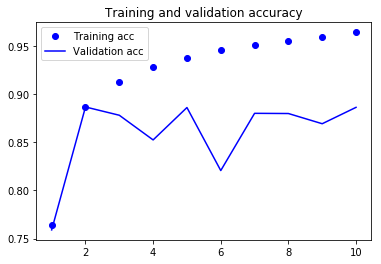

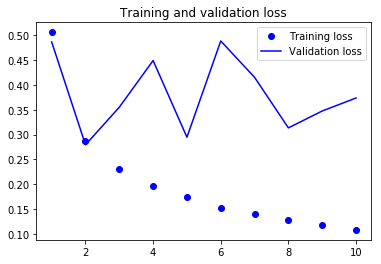

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 6.2.4 케라스를 사용한 GRU 예제

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU
from keras import backend as K

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['acc'])
history = model.fit(train_inputs, train_labels,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 43s 2ms/step - loss: 0.4962 - acc: 0.7468 - val_loss: 0.3444 - val_acc: 0.8566
Epoch 2/10
20000/20000 [==============================] - 41s 2ms/step - loss: 0.2887 - acc: 0.8848 - val_loss: 0.3360 - val_acc: 0.8596
Epoch 3/10
20000/20000 [==============================] - 41s 2ms/step - loss

In [6]:
import matplotlib.pyplot as plt

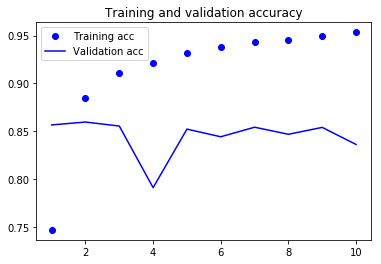

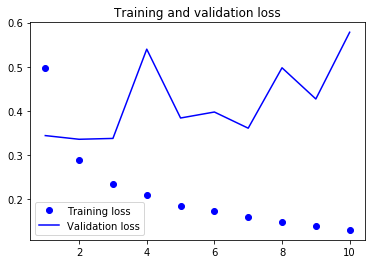

In [7]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 6.2.5 정리

• RNN이 무엇이고 동작하는 방법

• LSTM이 무엇이고 긴 시퀀스에서 단순한 RNN보다 더 잘 작동하는 이유

• 케라스의 RNN 층을 사용하여 시퀀스 데이터를 처리하는 방법